In [207]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import json
import os
from pandas import json_normalize
from datetime import datetime
import dataframe_image as dfi
import re

%matplotlib inline

In [208]:
# Set default figure size
plt.rcParams['figure.figsize'] = [16.0, 10.0]

# Paths
FIGURE_PATH = '../figures/'
DATA_PATH = '../sample-data/server1/reconcileDefaultNum/'
DATA_PATH_1MR = '../sample-data/server1/1MaxConcurrentReconcile/'
SERVER_2_DATA_PATH = '../sample-data/server2/1MaxConcurrentReconcile/'

# Data directory names
CPU_MEMORY_DIR = 'cpuMemory'
DEPLOYMENT_DIR = 'deployments'
PODS_DIR = 'pods'
TIMINGS_DIR = 'timings'
MEMCACHED_DIR = 'memcacheds'
STATEFULSETS_DIR = 'statefulsets'

# column nams
TYPE_COL = 'Type'
MAX_CON_REC_COL = 'Max Concurrent Reconcile'
DEFAULT_CONF_COL = 'Default Configuration'
CPU_LIM_COL = 'CPU Limit (Cores)'
MEM_LIM_COL = 'Memory Limit (Bytes)'

QUERY_TIME_COL = 'queryTimestamp'
MANGER_MEM_USAGE_COL = 'managerMemoryUsage (bytes)'
MANGER_CPU_USAGE_COL = 'managerCPUUsage (n)'
TIME_COL = 'time (s)'
KUBE_MEM_USAGE_COL = 'kubeMemoryUsage (bytes)'
KUBE_CPU_USAGE_COL = 'kubeCPUUsage (n)'

MEAN_COL = 'Mean'
STD_COL = 'Standard Deviation'
TIME_SEC_AX = 'Time (seconds)'
MEM_BYTE_AX = 'Memory (bytes)'
CPU_CORE_AX = 'CPU (cores)'
DIF_TIME_COL = 'difTime'

CR_KEY = 'crDir'
DEPLOY_KEY = 'deployDir'

In [209]:
# Create figure directory if it does not exist
if not os.path.exists(FIGURE_PATH):
    os.makedirs(FIGURE_PATH)

In [210]:
# Conversion
def convertToBytes(x):
    KILO = 'Ki'
    MILO = 'Mi'
    
    if KILO in x:
        t = int(x.replace(KILO, '')) * 1024
        return t
    elif MILO in x:
        t = int(x.replace(MILO, '')) * 1024 * 1024
        return t
    else:
         raise Exception(x)

def convertToCores(x):
    NANO = 'n'
    MICRO = 'u'
    MILLI = 'm'
    
    if NANO in x:
        t = int(x.replace(NANO, '')) * (10 ** -9)
        return t
    elif MICRO in x:
        t = int(x.replace(MICRO, '')) * (10 ** -6)
        return t
    elif MILLI in x:
        t = int(x.replace(MILLI, '')) * (10 ** -3)
    else:
         raise Exception(x)

def convertMilliToSeconds(x):
    return x / 1000


In [211]:
# Path 
def appendToDataPath(path):
    return DATA_PATH + path

def appendToDataPath1MR(path):
    return DATA_PATH_1MR + path

def appendToDataPathServer2(path):
    return SERVER_2_DATA_PATH + path

def getDefaultConfDirs():
    return getAllDirOfType(DATA_PATH, '-D')

def getCPUMemoryDir(baseDir):
    return baseDir + CPU_MEMORY_DIR

def getDeploymentDir(baseDir):
    return baseDir + DEPLOYMENT_DIR

def getPodsDir(baseDir):
    return baseDir + PODS_DIR

def getMemcachedsDir(baseDir):
    return baseDir + MEMCACHED_DIR

def getTimingsDir(baseDir):
    return baseDir + TIMINGS_DIR

def getStatefulSetsDir(baseDir):
    return baseDir + STATEFULSETS_DIR

def getAllDirOfType(baseDir, type):
    dirList = []
    for dir in os.listdir(baseDir):
        if type in dir:
            dirList.append(baseDir + dir + '/')
    
    return sorted(dirList)

In [212]:
def aggregateCPUMemory(directory):
    aggregatedDf = pd.DataFrame()
    
    cpuMemoryDir = getCPUMemoryDir(directory)
    
    # iterate over files in that directory
    for filename in os.listdir(cpuMemoryDir):
        f = os.path.join(cpuMemoryDir, filename)

        # Raw JSON data loaded into a dataframe
        rawDf = pd.read_json(f)
        # New dataframe to hold processed data
        processedDf = pd.DataFrame()

        # Get the creation timestamp
        processedDf[QUERY_TIME_COL] = rawDf.metadata.apply(pd.Series).creationTimestamp

        # Get the container usage for manager container
        managerContainerUsage = rawDf.containers.apply(pd.Series)[1].apply(pd.Series).usage.apply(pd.Series)

        # Process the CPU and Memory 
        processedDf[MANGER_MEM_USAGE_COL] = managerContainerUsage.memory.apply(convertToBytes)
        processedDf[MANGER_CPU_USAGE_COL] = managerContainerUsage.cpu.apply(convertToCores)

        processedDf[TIME_COL] = processedDf.index

        # Get the container usage for kube container
        kubeContainerUsage = rawDf.containers.apply(pd.Series)[0].apply(pd.Series).usage.apply(pd.Series)

        # Process the CPU and Memory 
        processedDf[KUBE_MEM_USAGE_COL] = kubeContainerUsage.memory.apply(convertToBytes)
        processedDf[KUBE_CPU_USAGE_COL] = kubeContainerUsage.cpu.apply(convertToCores)

        aggregatedDf = pd.concat([aggregatedDf, processedDf])
    
    return aggregatedDf

def getStatFromDF(df, col, innerCol, oType):
    idM = df[col][innerCol].idxmax()
    row = df[col].iloc[[idM]]
    row[TYPE_COL] = oType
    
    return row

def averageCPUMemoryUsage(directories, memUsageCol = MANGER_MEM_USAGE_COL, cpuUsageCol = MANGER_CPU_USAGE_COL , errorPlot = False):
    maxMemStats = pd.DataFrame()
    maxCPUStats = pd.DataFrame()
        
    for directory in directories:
        plt.figure(0)
        aggregatedDf = aggregateCPUMemory(directory)
        statsDf = groupByColumn(aggregatedDf, TIME_COL)

        # Plot Operator container - memory
        kubeCol = statsDf[memUsageCol]
        meanCol = kubeCol[MEAN_COL]
        stdCol = kubeCol[STD_COL]
        
        if errorPlot:
            plt.errorbar(statsDf.index, meanCol, yerr=std)
        else:
            plt.plot(statsDf.index, meanCol, label=getLegendBasedOnDir(directory))
        plt.legend()
        plt.xlabel(TIME_SEC_AX)
        plt.ylabel(MEM_BYTE_AX)

        maxMemStats = pd.concat([maxMemStats, getStatFromDF(statsDf, memUsageCol, 
                                                            MEAN_COL, getLegendBasedOnDir(directory))])

        # Plot Operator container - cpu
        plt.figure(1)
        kubeCol = statsDf[cpuUsageCol]
        meanCol = kubeCol[MEAN_COL]
        stdCol = kubeCol[STD_COL]
        
        if errorPlot:
            plt.errorbar(statsDf.index, meanCol, yerr=std)
        else:
            plt.plot(statsDf.index, meanCol, label=getLegendBasedOnDir(directory))
        plt.legend()
        plt.xlabel(TIME_SEC_AX)
        plt.ylabel(CPU_CORE_AX)

        maxCPUStats = pd.concat([maxCPUStats, getStatFromDF(statsDf, cpuUsageCol, 
                                                      MEAN_COL, getLegendBasedOnDir(directory))])
        
    return maxMemStats, maxCPUStats    

def getLegendBasedOnDir(dir):
    for x in [DATA_PATH, SERVER_2_DATA_PATH, DATA_PATH_1MR]:
        m = re.search(x + '(.+?)/', dir)
        if m:
            return m.group(1)
    
    return 'unknown'

def saveFig(fileName):
    plt.savefig(FIGURE_PATH + fileName, bbox_inches='tight')
    
def timeDifferenceBetweenTwoColumns(df, column1, column2):
    dateformat = '%Y-%m-%dT%H:%M:%SZ'

    listOfTimeDif = []
    for index, row in df.iterrows():
        t1 = datetime.strptime(row[column1], dateformat)
        t2 = datetime.strptime(row[column2], dateformat)

        # get difference
        delta = t2 - t1

        # time difference in seconds
        listOfTimeDif.append(delta.total_seconds())
    
    return listOfTimeDif


def normaliseJSONMeta(f):
    with open(f) as data_file:    
        d = json.load(data_file)  

    df = json_normalize(d, 'items').assign(**d['metadata'])
    
    return df

def generateAndSaveMeanTables(df, name1, name2):
    # Save maxstats table
    saveTableAsImage(df, name1)

    # Generate a ratio
    ratioTable = generateRatioTable(df)
    
    ratioTable.columns = ratioTable.columns.str.capitalize()
    ratioTable.index.names = [item.capitalize() for item in ratioTable.index.names]

    saveTableAsImage(ratioTable, name2)
    
def generateRatioTable(df):
    ratioTable = pd.DataFrame()
    
    if TYPE_COL in df:
        ratioTable[TYPE_COL] = df[TYPE_COL]
    
    for index, row in df.iterrows():
        scaler = row[MEAN_COL]
        if TYPE_COL in df:
            ratioTable[row[TYPE_COL]] = df[MEAN_COL] / scaler
        else:
            ratioTable[index] = df[MEAN_COL] / scaler
    
    return ratioTable

def saveTableAsImage(df, fileName):
    dfi.export(df, FIGURE_PATH + fileName)


def barChartBetweenType(statsDf, column, yLabel, title):
    plt.bar(statsDf[column].index, statsDf[column][MEAN_COL], color=['#1f77b4', '#ff7f0e', '#2ca02c'], 
            yerr=statsDf[column][STD_COL], capsize=10)
    plt.ylabel(yLabel)
    plt.title(title)

def operartorPodReady(directories):
    controllerPodDf = pd.DataFrame()
    limitsDf = pd.DataFrame()

    # iterate over files in that directory
    for directory in directories: 
        podDir = directory + PODS_DIR
        aggregatedDf = pd.DataFrame()
        for filename in os.listdir(podDir):
            f = os.path.join(podDir, filename)
            df = normaliseJSONMeta(f)

            processedDf = pd.DataFrame()
            processedDf['podName'] = df['metadata.name']
            processedDf['createTime'] = df['metadata.creationTimestamp']

            conditions = df['status.conditions']
            readyConditionList = []
            for index, row in conditions.iteritems():
                rowDf = json_normalize(row)
                readyCondition = rowDf.loc[rowDf['type'] == 'Ready']['lastTransitionTime']
                readyConditionList.append(readyCondition.iat[0])


            processedDf = processedDf.assign(readyTime=readyConditionList)
            processedDf = processedDf.assign(difTime=timeDifferenceBetweenTwoColumns(processedDf, 'createTime', 'readyTime'))
            processedDf['type'] = getLegendBasedOnDir(directory)

            aggregatedDf = pd.concat([aggregatedDf, processedDf])

        # Filter to get only the controller pod     
        filterController = aggregatedDf[aggregatedDf['podName'].str.contains("controller")]
        controllerPodDf = pd.concat([controllerPodDf, filterController])

        # Get limits of manager container    
        containers = json_normalize(df['spec.containers'][0])
        row = containers.loc[containers['name'] == 'manager']

        limit = pd.DataFrame()
        limit[CPU_LIM_COL] = row['resources.limits.cpu']
        limit[MEM_LIM_COL] = row['resources.limits.memory']
        limit[TYPE_COL] = getLegendBasedOnDir(directory)

        limitsDf = pd.concat([limitsDf, limit])
  
    limitsDf = limitsDf.reset_index(drop=True)
    return controllerPodDf, limitsDf

def timeForMemPodsDf(directories):
    timingDf = pd.DataFrame()
    # iterate over files in that directory
    for directory in directories: 
        timingDir = directory + TIMINGS_DIR
        for filename in os.listdir(timingDir):
            f = os.path.join(timingDir, filename)
            with open(f) as data_file:    
                d = json.load(data_file)  

            df = json_normalize(d).assign(**d)
            df['type'] = getLegendBasedOnDir(directory)

            timingDf = pd.concat([timingDf, df])

    timingDf['timeForPodsRunning'] = timingDf['timeForPodsRunning'].apply(convertMilliToSeconds)
    timingDf['timeForPodsDeleted'] = timingDf['timeForPodsDeleted'].apply(convertMilliToSeconds)
    
    return timingDf

def getBaseData(df, label):
    processedDf = pd.DataFrame()
    processedDf['name'] = df['metadata.name']
    processedDf['createTime'] = df['metadata.creationTimestamp']
    processedDf['number'] = df.index
    processedDf['type'] = label

    return processedDf

def plotTimeBetweenCRAndDeployment(directoriesMap, errorPlot = False):
    
    everythingDf = pd.DataFrame()

    for directory in directoriesMap: 
        aggregatedCRDf = pd.DataFrame()
        aggredatedDeployDf = pd.DataFrame()

        crDir = directory[CR_KEY]
        deployDir = directory[DEPLOY_KEY]
        label = getLegendBasedOnDir(deployDir)
        
        if 'label' in directory:
            label = directory['label']

        for filename in sorted(os.listdir(crDir)):
            f = os.path.join(crDir, filename)
            df = normaliseJSONMeta(f)

            processedDf = getBaseData(df, label)
            aggregatedCRDf = pd.concat([aggregatedCRDf, processedDf])

        for filename in sorted(os.listdir(deployDir)):
            f = os.path.join(deployDir, filename)
            df = normaliseJSONMeta(f)

            processedDf = getBaseData(df, label)

            filterMem = processedDf[processedDf['name'].str.contains("sample")]
            aggredatedDeployDf = pd.concat([aggredatedDeployDf, filterMem])

        aggregatedCRDf['deployCreateTime'] = aggredatedDeployDf['createTime'].to_numpy()
        aggregatedCRDf = aggregatedCRDf.assign(
            difTime=timeDifferenceBetweenTwoColumns(aggregatedCRDf, 'createTime', 'deployCreateTime'))

        everythingDf = pd.concat([everythingDf, aggregatedCRDf])

    #     Error bar plot
        statsDf = groupByColumn(aggregatedCRDf, 'number')
        if errorPlot:
            plt.errorbar(statsDf.index, statsDf[DIF_TIME_COL][MEAN_COL], yerr=statsDf[DIF_TIME_COL][STD_COL], 
                     label=label, capsize=5, marker='o')
        else:
            plt.plot(statsDf.index, statsDf[DIF_TIME_COL][MEAN_COL], label=label, marker='o')
   

    plt.ylabel(TIME_SEC_AX)
    plt.xlabel('Memcached CR Number')
    plt.legend()
    
    return everythingDf

def groupByColumn(df, col, sort = True):
    statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
    statsDf.index.names = [col.capitalize()]
    
    return statsDf.rename(columns={"mean": MEAN_COL, "std": STD_COL, 
                                   "min": "Minimum", "max": "Maximum", "sem": "Standard Error of the Mean"})


def getMainTypeFromDir(dir):
    if 'helm' in dir:
        return 'Helm'
    elif 'ansible' in dir:
        return 'Ansible'
    elif 'go' in dir:
        return 'Go'
    
    return 'unknown'

def isDefaultConfiguration(df):
    if df[TYPE_COL].values[0] == 'Helm':
        return df[CPU_LIM_COL].values[0] == '500m' and df[MEM_LIM_COL].values[0] == '128Mi' and df[MAX_CON_REC_COL].values[0] == 4
    elif df[TYPE_COL].values[0] == 'Ansible':
        return df[CPU_LIM_COL].values[0] == '500m' and df[MEM_LIM_COL].values[0] == '768Mi' and df[MAX_CON_REC_COL].values[0] == 4
    else:
        return df[CPU_LIM_COL].values[0] == '500m' and df[MEM_LIM_COL].values[0] == '128Mi' and df[MAX_CON_REC_COL].values[0] == 1

def getManagerContainerFromDf(df):
    containers = json_normalize(df['spec.containers'][0])
    return containers.loc[containers['name'] == 'manager']
    

def getLimitDfFromContainer(container):
    limit = pd.DataFrame()
    limit[CPU_LIM_COL] = container['resources.limits.cpu']
    limit[MEM_LIM_COL] = container['resources.limits.memory']
    
    return limit

def getMaxConcurrentReconcileFromArgs(dir, container):
    MAX_CON_REC_FLAG = '--max-concurrent-reconciles='
    
    containerArgs = container['args'].values[0]

    # Go Default is one        
    maxConRencile = 1
    # The other two is defaulted at 4 which is the number of CPU cores available            
    if 'helm' in dir or 'ansible' in dir:
        maxConRencile = 4

    # Check for flag - can be set in helm and ansible         
    for x in containerArgs:
        if MAX_CON_REC_FLAG not in x:
            continue
        elif MAX_CON_REC_FLAG in x:
            maxConRencile = x.split(MAX_CON_REC_FLAG)[1]
            
    return maxConRencile

def getLimiFromPodsDir(parentDirectory):
    limitsDf = pd.DataFrame()

    for directory in os.listdir(parentDirectory): 
        aggregatedDf = pd.DataFrame()
        podDir = getPodsDir(parentDirectory + directory + '/')
        for filename in os.listdir(podDir):
            f = os.path.join(podDir, filename)
            df = normaliseJSONMeta(f)
        
        # Get limits of manager container    
        container = getManagerContainerFromDf(df)

        limit = getLimitDfFromContainer(container)
        limit[TYPE_COL] = getMainTypeFromDir(podDir)
        limit[MAX_CON_REC_COL] = [getMaxConcurrentReconcileFromArgs(directory, container)]
        limit[DEFAULT_CONF_COL] = isDefaultConfiguration(limit)
            
        limitsDf = pd.concat([limitsDf, limit])
    return limitsDf

def generateTestVariationsTable(directories):
    limitsDf = pd.DataFrame()

    # iterate over files in that directory
    for parentDirectory in directories: 
            limitsDf = pd.concat([limitsDf, getLimiFromPodsDir(parentDirectory)])
    
    limitsDf = limitsDf.sort_values(by=[TYPE_COL, MAX_CON_REC_COL, CPU_LIM_COL, MEM_LIM_COL])
    limitsDf = limitsDf.reset_index(drop=True)
    return limitsDf

def getCRAndDeployDirectory(baseDir, appendFn):
    return {
        CR_KEY: appendFn(getMemcachedsDir(baseDir)),
        DEPLOY_KEY: appendFn(getDeploymentDir(baseDir))
    }

def getCRAndStateDirectory(baseDir, appendFn):
    return {
        CR_KEY: appendFn(getMemcachedsDir(baseDir)),
        DEPLOY_KEY: appendFn(getStatefulSetsDir(baseDir))
    }

# 0 Table of Test Variations

In [213]:
table = generateTestVariationsTable([DATA_PATH, DATA_PATH_1MR])
table

,CPU Limit (Cores),Memory Limit (Bytes),Type,Max Concurrent Reconcile,Default Configuration
0,1,1536Mi,Ansible,4,False
1,1,768Mi,Ansible,4,False
2,500m,1536Mi,Ansible,4,False
3,500m,768Mi,Ansible,4,True
4,1,1536Mi,Ansible,1,False
5,1,768Mi,Ansible,1,False
6,500m,1536Mi,Ansible,1,False
7,500m,768Mi,Ansible,1,False
8,1,128Mi,Go,1,False
9,1,1536Mi,Go,1,False


In [214]:
saveTableAsImage(table, 'tableTestingConfiguration.png')

[0904/184212.564462:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184212.639374:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184212.815873:INFO:headless_shell.cc(660)] Written to file /tmp/tmp55d4hor3/temp.png.


# 1 CPU & Memory
## 1.1 Ansible
### 1.1.1 Max Current Reconcile 1

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not agg

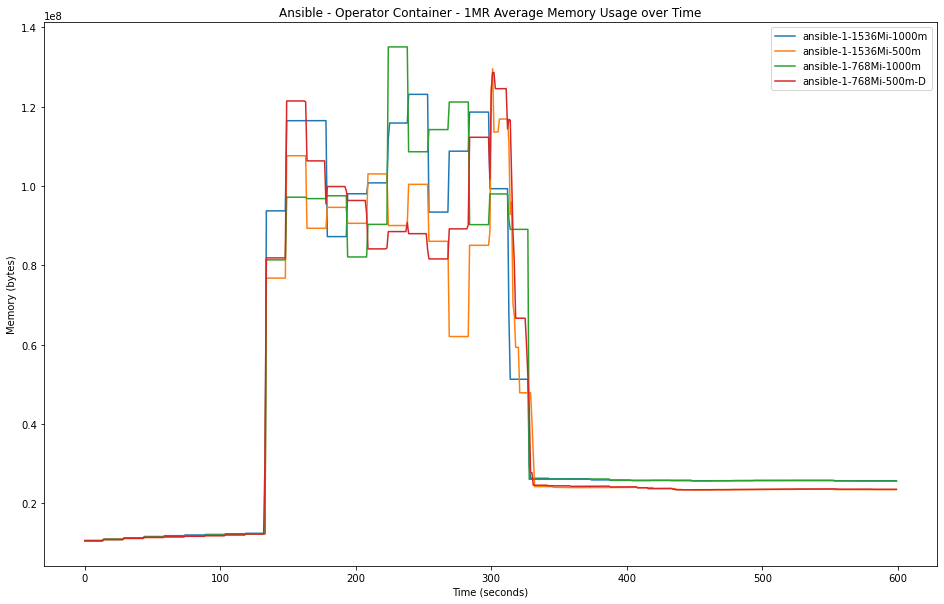

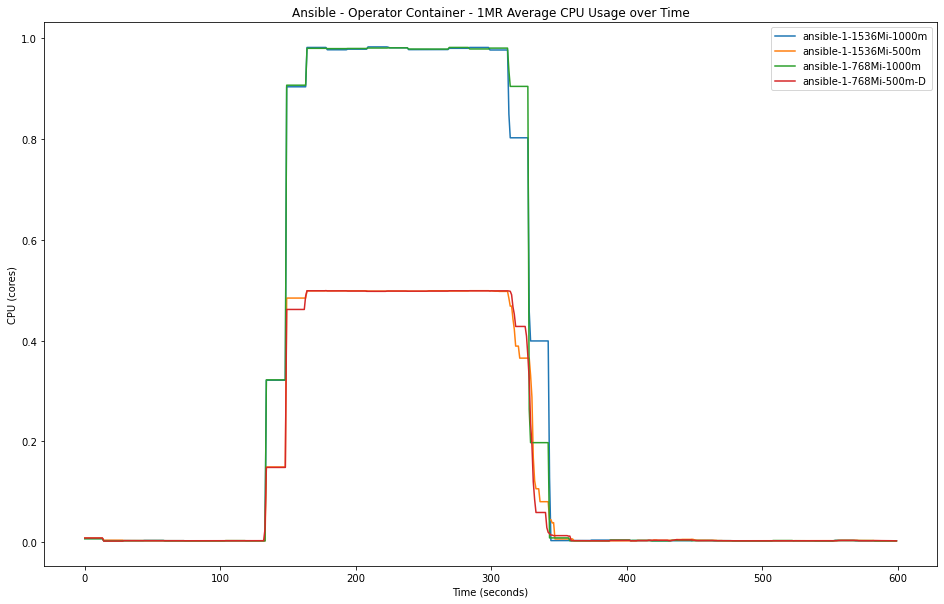

In [215]:
allMemStats = pd.DataFrame()
allCPUStats = pd.DataFrame()

directories = getAllDirOfType(DATA_PATH_1MR, 'ansible')
maxMemStats, maxCPUStats =  averageCPUMemoryUsage(directories)

allMemStats = pd.concat([allMemStats, maxMemStats])
allCPUStats = pd.concat([allCPUStats, maxCPUStats])

plt.figure(0)
plt.title("Ansible - Operator Container - 1MR Average Memory Usage over Time")
saveFig('plotAnsible1MRMemoryUsage.png')

plt.figure(1)
plt.title("Ansible - Operator Container - 1MR Average CPU Usage over Time")
saveFig('plotAnsible1MRCpuUsage.png')

In [216]:
saveTableAsImage(maxMemStats, 'tableAnsible1MRMaxMemoryUsage.png')
maxMemStats

[0904/184240.828229:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184240.903754:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184241.060685:INFO:headless_shell.cc(660)] Written to file /tmp/tmpaxnvxyko/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
239,123092992.0,3.716839e+07,73371648,185798656,1.175368e+07,ansible-1-1536Mi-1000m
301,129558118.4,5.901077e+07,52043776,207450112,1.866084e+07,ansible-1-1536Mi-500m
224,135058636.8,4.205011e+07,97751040,205979648,1.329741e+07,ansible-1-768Mi-1000m
301,128598835.2,5.398461e+07,51765248,207126528,1.707143e+07,ansible-1-768Mi-500m-D


In [217]:
saveTableAsImage(maxCPUStats, 'tableAnsible1MRMaxCpuUsage.png')
maxCPUStats

[0904/184241.224825:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184241.285201:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184241.423961:INFO:headless_shell.cc(660)] Written to file /tmp/tmp5mi1nvni/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
209,0.983081,0.003404,0.976894,0.988781,0.001077,ansible-1-1536Mi-1000m
284,0.499195,0.001485,0.497507,0.501328,0.000470,ansible-1-1536Mi-500m
269,0.982028,0.003729,0.976170,0.987947,0.001179,ansible-1-768Mi-1000m
178,0.499390,0.000920,0.498337,0.501472,0.000291,ansible-1-768Mi-500m-D


### 1.1.2 Max Concurrent Reconcile - Default - 4

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not agg

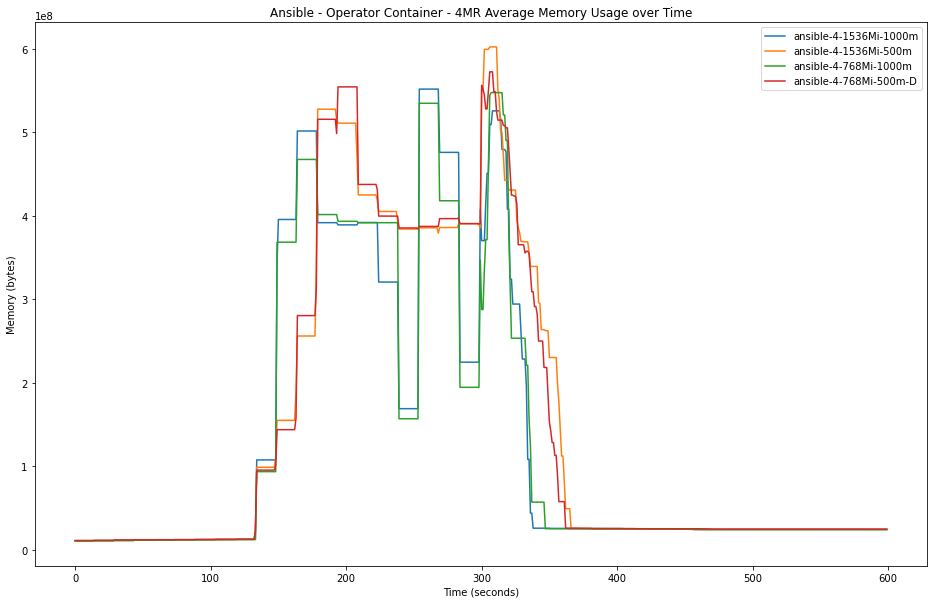

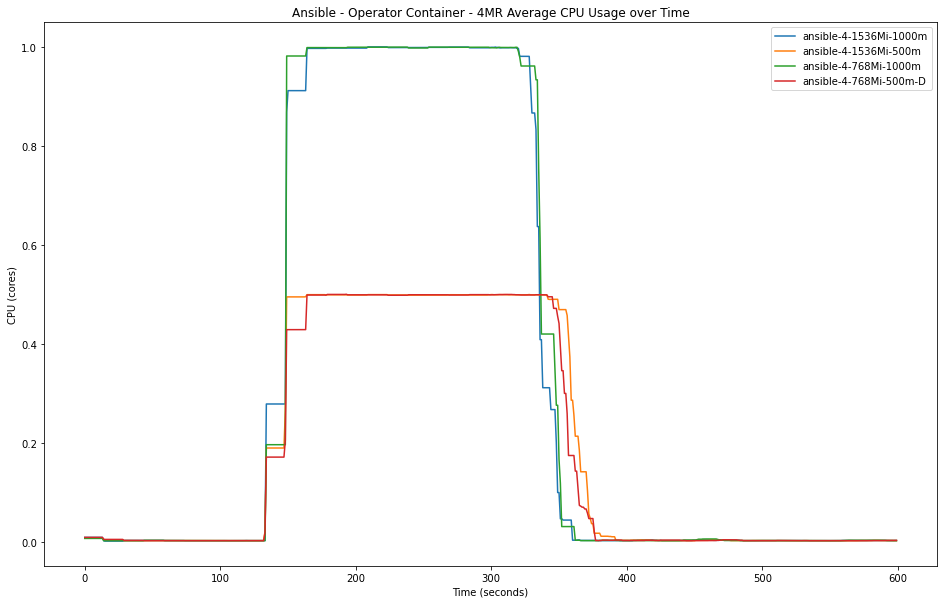

In [218]:
directories = getAllDirOfType(DATA_PATH, 'ansible')
maxMemStats, maxCPUStats =  averageCPUMemoryUsage(directories)

allMemStats = pd.concat([allMemStats, maxMemStats])
allCPUStats = pd.concat([allCPUStats, maxCPUStats])

plt.figure(0)
plt.title("Ansible - Operator Container - 4MR Average Memory Usage over Time")
saveFig('plotAnsible4MRMemoryUsage.png')

plt.figure(1)
plt.title("Ansible - Operator Container - 4MR Average CPU Usage over Time")
saveFig('plotAnsible4MRCpuUsage.png')

In [219]:
saveTableAsImage(maxMemStats, 'tableAnsible4MRMaxMemoryUsage.png')
maxMemStats

[0904/184318.454416:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184318.533629:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184318.694586:INFO:headless_shell.cc(660)] Written to file /tmp/tmp95pb8ug8/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
254,551969177.6,1.579043e+08,264740864,718077952,4.993371e+07,ansible-4-1536Mi-1000m
306,602532659.2,7.800791e+07,435425280,697667584,2.466827e+07,ansible-4-1536Mi-500m
307,547747430.4,1.237636e+08,333885440,694894592,3.913750e+07,ansible-4-768Mi-1000m
306,572662169.6,1.282508e+08,364544000,729993216,4.055647e+07,ansible-4-768Mi-500m-D


In [220]:
saveTableAsImage(maxCPUStats, 'tableAnsible4MRMaxCpuUsage.png')
maxCPUStats

[0904/184318.869067:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184318.953573:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184319.111946:INFO:headless_shell.cc(660)] Written to file /tmp/tmpcepozo_y/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
209,1.000662,0.002190,0.997352,1.003845,0.000693,ansible-4-1536Mi-1000m
328,0.500203,0.000717,0.499164,0.501573,0.000227,ansible-4-1536Mi-500m
224,1.000234,0.001443,0.998356,1.002658,0.000456,ansible-4-768Mi-1000m
193,0.500771,0.001015,0.498734,0.502174,0.000321,ansible-4-768Mi-500m-D


## 1.2 Helm
### 1.2.1 Max Concurrent Reconcile 1

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not agg

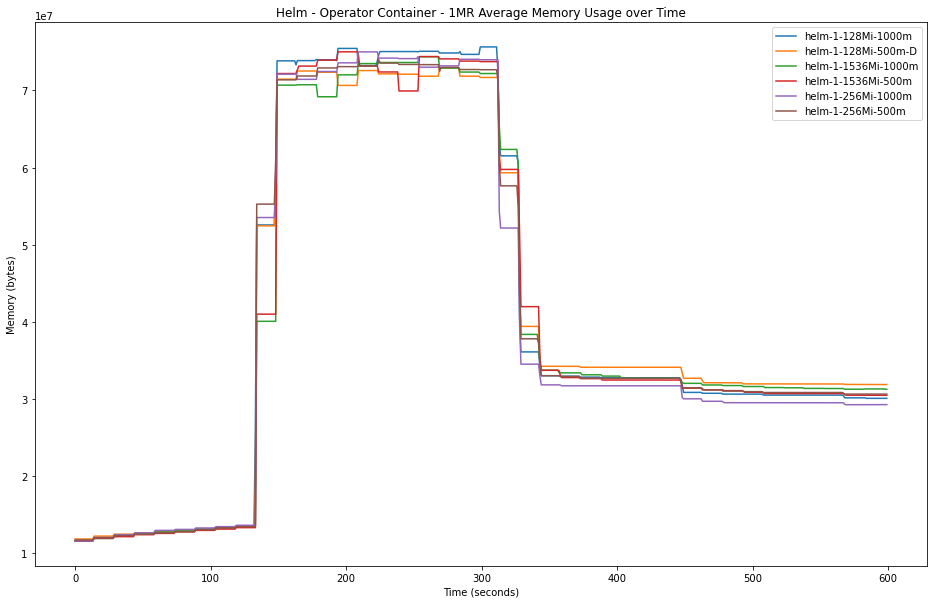

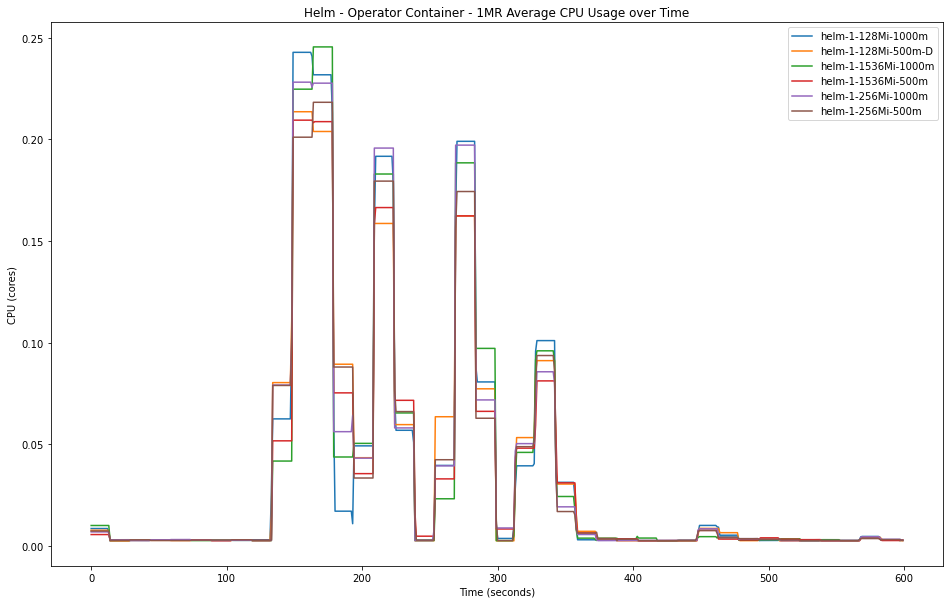

In [221]:
directories = getAllDirOfType(DATA_PATH_1MR, 'helm')
maxMemStats, maxCPUStats =  averageCPUMemoryUsage(directories)

allMemStats = pd.concat([allMemStats, maxMemStats])
allCPUStats = pd.concat([allCPUStats, maxCPUStats])

plt.figure(0)
plt.title("Helm - Operator Container - 1MR Average Memory Usage over Time")
saveFig('plotHelm1MRMemoryUsage.png')

plt.figure(1)
plt.title("Helm - Operator Container - 1MR Average CPU Usage over Time")
saveFig('plotHelm1MRCpuUsage.png')

In [222]:
saveTableAsImage(maxMemStats, 'tableHelm1MRMaxMemoryUsage.png')
maxMemStats

[0904/184405.016242:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184405.090007:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184405.282908:INFO:headless_shell.cc(660)] Written to file /tmp/tmpe6m8_3ph/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
299,7.564943e+07,2.068666e+06,73502720,79204352,6.541698e+05,helm-1-128Mi-1000m
269,7.293256e+07,2.487926e+06,67497984,75649024,7.867514e+05,helm-1-128Mi-500m-D
254,7.436971e+07,3.347666e+06,70098944,81551360,1.115889e+06,helm-1-1536Mi-1000m
194,7.501169e+07,2.758115e+06,70184960,79769600,8.721925e+05,helm-1-1536Mi-500m
209,7.500677e+07,2.680211e+06,71397376,78950400,8.475571e+05,helm-1-256Mi-1000m
224,7.400489e+07,4.036421e+06,65085440,79400960,1.276428e+06,helm-1-256Mi-500m


In [223]:
saveTableAsImage(maxCPUStats, 'tableHelm1MRMaxCpuUsage.png')
maxCPUStats

[0904/184405.466295:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184405.549423:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184405.740920:INFO:headless_shell.cc(660)] Written to file /tmp/tmpqggotak5/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
149,0.242779,0.006790,0.233982,0.252391,0.002147,helm-1-128Mi-1000m
149,0.213581,0.014160,0.183057,0.231222,0.004478,helm-1-128Mi-500m-D
164,0.245445,0.011252,0.219934,0.260656,0.003751,helm-1-1536Mi-1000m
149,0.209436,0.012904,0.182154,0.226815,0.004080,helm-1-1536Mi-500m
149,0.228107,0.036172,0.128292,0.251380,0.011439,helm-1-256Mi-1000m
164,0.218219,0.002862,0.215104,0.222279,0.000905,helm-1-256Mi-500m


### 1.2.2 Max Concurrent Reconcile - Default - 4

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not agg

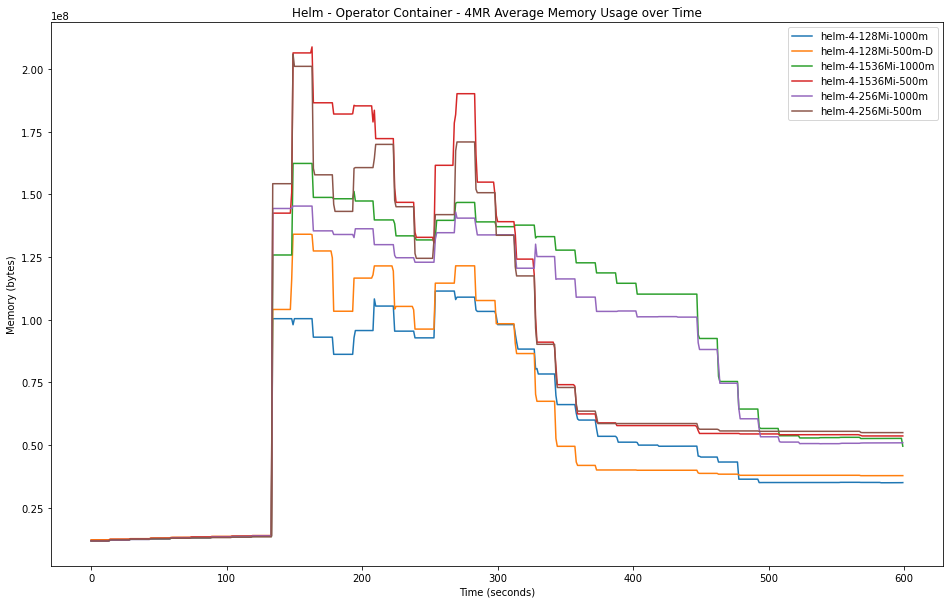

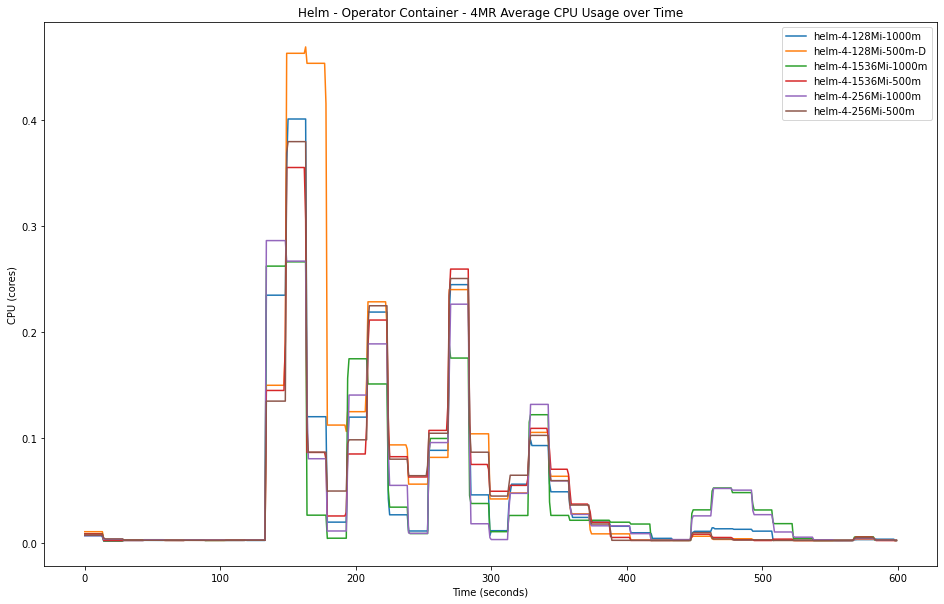

In [224]:
directories = getAllDirOfType(DATA_PATH, 'helm')
maxMemStats, maxCPUStats =  averageCPUMemoryUsage(directories)

allMemStats = pd.concat([allMemStats, maxMemStats])
allCPUStats = pd.concat([allCPUStats, maxCPUStats])

plt.figure(0)
plt.title("Helm - Operator Container - 4MR Average Memory Usage over Time")
saveFig('plotHelm4MRMemoryUsage.png')

plt.figure(1)
plt.title("Helm - Operator Container - 4MR Average CPU Usage over Time")
saveFig('plotHelm4MRCpuUsage.png')

In [225]:
saveTableAsImage(maxMemStats, 'tableHelm4MRMaxMemoryUsage.png')
maxMemStats

[0904/184448.259914:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184448.345026:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184448.510207:INFO:headless_shell.cc(660)] Written to file /tmp/tmpkygvbax0/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
254,111360819.2,1.830841e+07,80449536,131756032,5.789629e+06,helm-4-128Mi-1000m
149,134027673.6,1.578623e+05,133709824,134217728,4.992044e+04,helm-4-128Mi-500m-D
149,162276556.8,3.271791e+07,118169600,208941056,1.034631e+07,helm-4-1536Mi-1000m
163,208766976.0,2.147747e+07,158617600,232194048,7.593431e+06,helm-4-1536Mi-500m
149,145264640.0,4.480936e+07,89579520,205512704,1.493645e+07,helm-4-256Mi-1000m
149,205839974.4,2.722684e+07,159465472,229908480,8.609882e+06,helm-4-256Mi-500m


In [226]:
saveTableAsImage(maxCPUStats, 'tableHelm4MRMaxCpuUsage.png')
maxCPUStats

[0904/184448.692036:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184448.766305:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184448.946205:INFO:headless_shell.cc(660)] Written to file /tmp/tmpjyyhs2_n/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
150,0.400949,0.147160,0.181936,0.592652,0.046536,helm-4-128Mi-1000m
163,0.469068,0.065194,0.288693,0.500806,0.020616,helm-4-128Mi-500m-D
149,0.265977,0.194969,0.002146,0.535453,0.061655,helm-4-1536Mi-1000m
149,0.355118,0.061417,0.249916,0.450774,0.021714,helm-4-1536Mi-500m
134,0.286060,0.121333,0.110362,0.431091,0.040444,helm-4-256Mi-1000m
150,0.379570,0.093612,0.153839,0.460581,0.029603,helm-4-256Mi-500m


## 1.3 Go
### 1.3.1 Max Concurrent Reconcile - Default - 1

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not agg

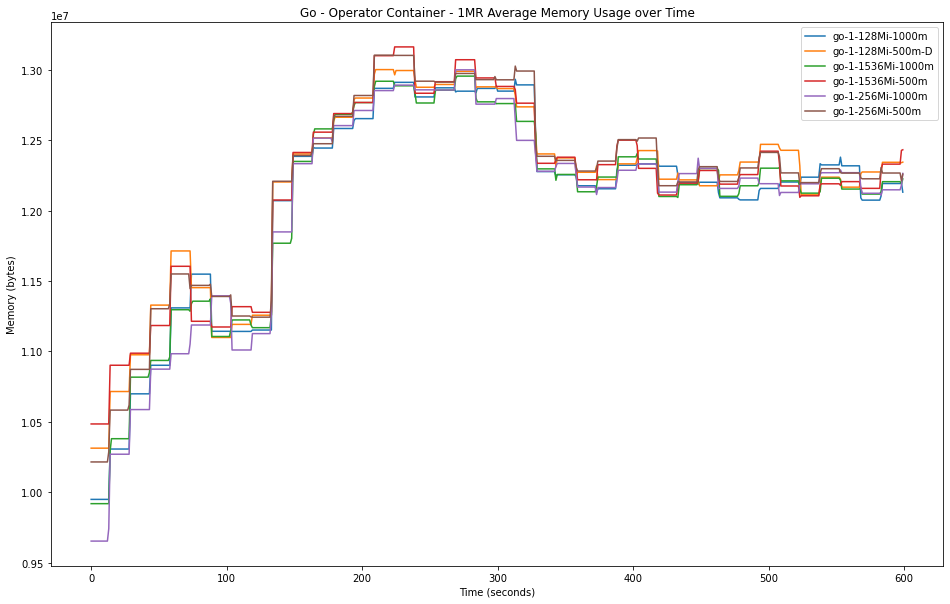

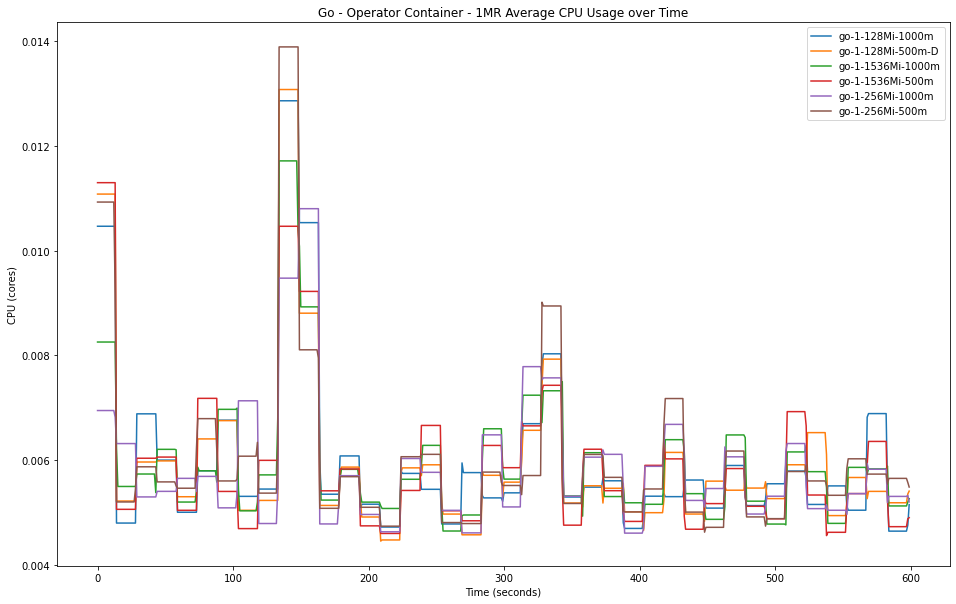

In [227]:
directories = getAllDirOfType(DATA_PATH, 'go')
maxMemStats, maxCPUStats =  averageCPUMemoryUsage(directories)

allMemStats = pd.concat([allMemStats, maxMemStats])
allCPUStats = pd.concat([allCPUStats, maxCPUStats])

plt.figure(0)
plt.title("Go - Operator Container - 1MR Average Memory Usage over Time")
saveFig('plotGo1MRMemoryUsage.png')

plt.figure(1)
plt.title("Go - Operator Container - 1MR Average CPU Usage over Time")
saveFig('plotGo1MRCpuUsage.png')

In [228]:
saveTableAsImage(maxMemStats, 'tableGo1MRMaxMemoryUsage.png')
maxMemStats

[0904/184533.254045:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184533.338713:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184533.506619:INFO:headless_shell.cc(660)] Written to file /tmp/tmprg34dwpw/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
313,1.293189e+07,365826.792680,12619776,13873152,115684.589398,go-1-128Mi-1000m
210,1.300070e+07,257596.105202,12439552,13418496,81459.040883,go-1-128Mi-500m-D
270,1.295442e+07,230301.017355,12509184,13406208,72827.576230,go-1-1536Mi-1000m
224,1.316181e+07,351546.821007,12767232,13742080,117182.273669,go-1-1536Mi-500m
269,1.299907e+07,301551.415805,12652544,13418496,95358.930559,go-1-256Mi-1000m
209,1.310310e+07,283161.048520,12718080,13504512,89543.385797,go-1-256Mi-500m


In [229]:
saveTableAsImage(maxCPUStats, 'tableGo1MaxCpuUsage.png')
maxCPUStats

[0904/184533.692685:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184533.774813:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184533.958076:INFO:headless_shell.cc(660)] Written to file /tmp/tmp2e77yzj8/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
134,0.012865,0.004665,0.004801,0.019893,0.001475,go-1-128Mi-1000m
134,0.013080,0.002187,0.010696,0.017253,0.000691,go-1-128Mi-500m-D
134,0.011717,0.004190,0.006533,0.017526,0.001325,go-1-1536Mi-1000m
0,0.011300,0.005204,0.004951,0.017428,0.001735,go-1-1536Mi-500m
149,0.010803,0.004295,0.005902,0.018574,0.001358,go-1-256Mi-1000m
134,0.013895,0.004000,0.006808,0.018902,0.001265,go-1-256Mi-500m


## 1.4 Point of Highest Memory Usage

In [230]:
allMemStats

,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
239,1.230930e+08,3.716839e+07,73371648,185798656,1.175368e+07,ansible-1-1536Mi-1000m
301,1.295581e+08,5.901077e+07,52043776,207450112,1.866084e+07,ansible-1-1536Mi-500m
224,1.350586e+08,4.205011e+07,97751040,205979648,1.329741e+07,ansible-1-768Mi-1000m
301,1.285988e+08,5.398461e+07,51765248,207126528,1.707143e+07,ansible-1-768Mi-500m-D
254,5.519692e+08,1.579043e+08,264740864,718077952,4.993371e+07,ansible-4-1536Mi-1000m
306,6.025327e+08,7.800791e+07,435425280,697667584,2.466827e+07,ansible-4-1536Mi-500m
307,5.477474e+08,1.237636e+08,333885440,694894592,3.913750e+07,ansible-4-768Mi-1000m
306,5.726622e+08,1.282508e+08,364544000,729993216,4.055647e+07,ansible-4-768Mi-500m-D
299,7.564943e+07,2.068666e+06,73502720,79204352,6.541698e+05,helm-1-128Mi-1000m


## 1.5 Point of Highest CPU Usage

In [231]:
allCPUStats

,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
209,0.983081,0.003404,0.976894,0.988781,0.001077,ansible-1-1536Mi-1000m
284,0.499195,0.001485,0.497507,0.501328,0.000470,ansible-1-1536Mi-500m
269,0.982028,0.003729,0.976170,0.987947,0.001179,ansible-1-768Mi-1000m
178,0.499390,0.000920,0.498337,0.501472,0.000291,ansible-1-768Mi-500m-D
209,1.000662,0.002190,0.997352,1.003845,0.000693,ansible-4-1536Mi-1000m
328,0.500203,0.000717,0.499164,0.501573,0.000227,ansible-4-1536Mi-500m
224,1.000234,0.001443,0.998356,1.002658,0.000456,ansible-4-768Mi-1000m
193,0.500771,0.001015,0.498734,0.502174,0.000321,ansible-4-768Mi-500m-D
149,0.242779,0.006790,0.233982,0.252391,0.002147,helm-1-128Mi-1000m


# 2 Pod Creation Time
## 2.1 Ansible
### 2.1.1 Max Concurrent Reconcile - Default - 4

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

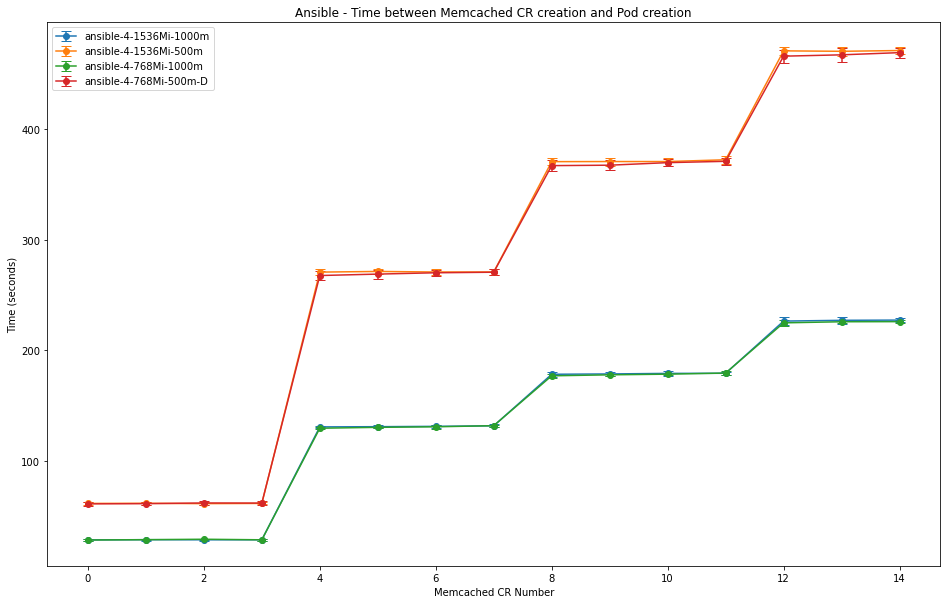

In [232]:
ansibleDirectories = [{
    CR_KEY: getMemcachedsDir(x),
    DEPLOY_KEY: getDeploymentDir(x),
} for x in getAllDirOfType(DATA_PATH, 'ansible')]

everythingDf = plotTimeBetweenCRAndDeployment(ansibleDirectories, True)

plt.title('Ansible - Time between Memcached CR creation and Pod creation')
saveFig('plotAnsibleTimeBetweenCRAndDeployment.png')

statsTable = groupByColumn(everythingDf, 'type')[DIF_TIME_COL]
saveTableAsImage(statsTable, 'tableStatsAnsible4Reconcile.png')

### 2.1.2 Max Concurrent Reconcile 1

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

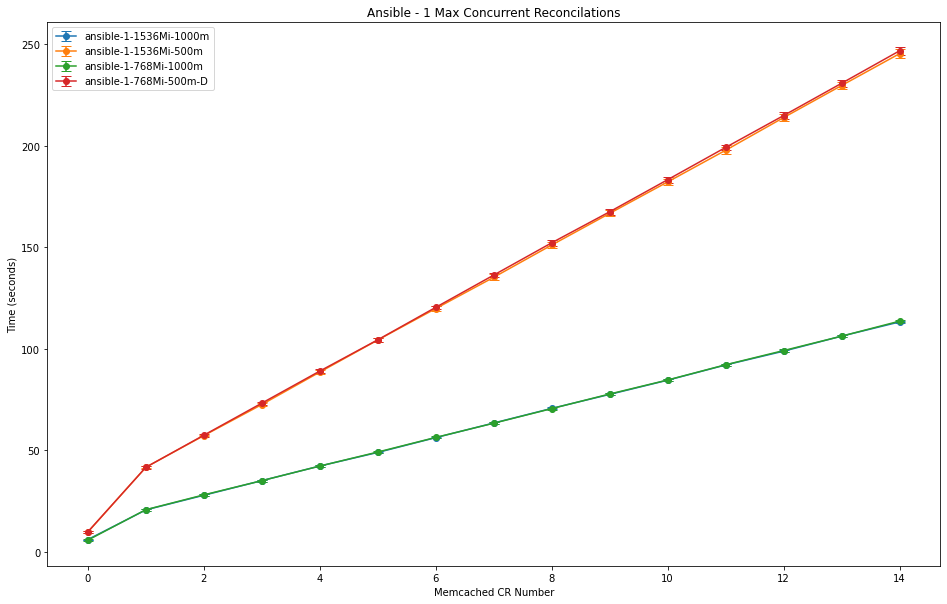

In [233]:
directories = [{
    CR_KEY: getMemcachedsDir(x),
    DEPLOY_KEY: getDeploymentDir(x),
} for x in getAllDirOfType(DATA_PATH_1MR, 'ansible')]

plt.title('Ansible - 1 Max Concurrent Reconcilations')
everythingDf = plotTimeBetweenCRAndDeployment(directories, True)
saveFig('plotAnsible1Reconcile.png')

statsTable = groupByColumn(everythingDf, 'type')[DIF_TIME_COL]
saveTableAsImage(statsTable, 'tableStatsAnsible1Reconcile.png')

## 2.2 Helm
### 2.2.1 Max Concurrent Reconcile - Default - 4

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

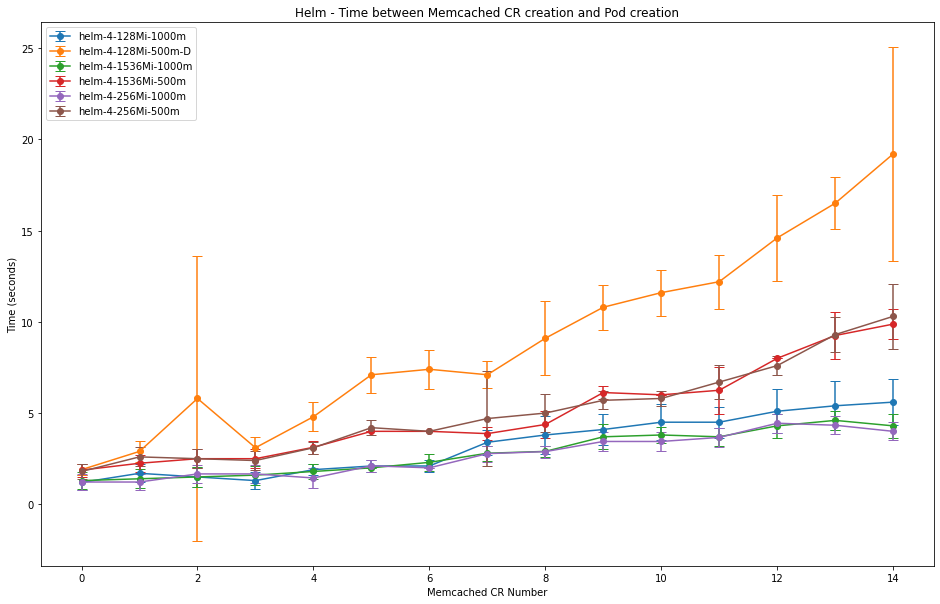

In [234]:
helmDirectories = [{
    CR_KEY: getMemcachedsDir(x),
    DEPLOY_KEY: getStatefulSetsDir(x),
} for x in getAllDirOfType(DATA_PATH, 'helm')]

everythingDf = plotTimeBetweenCRAndDeployment(helmDirectories, True)

plt.title('Helm - Time between Memcached CR creation and Pod creation')
saveFig('plotHelmTimeBetweenCRAndDeployment.png')

statsTable = groupByColumn(everythingDf, 'type')[DIF_TIME_COL]
saveTableAsImage(statsTable, 'tableStatsHelm4Reconcile.png')

### 2.2.2 Max Concurrent Reconcile 1

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

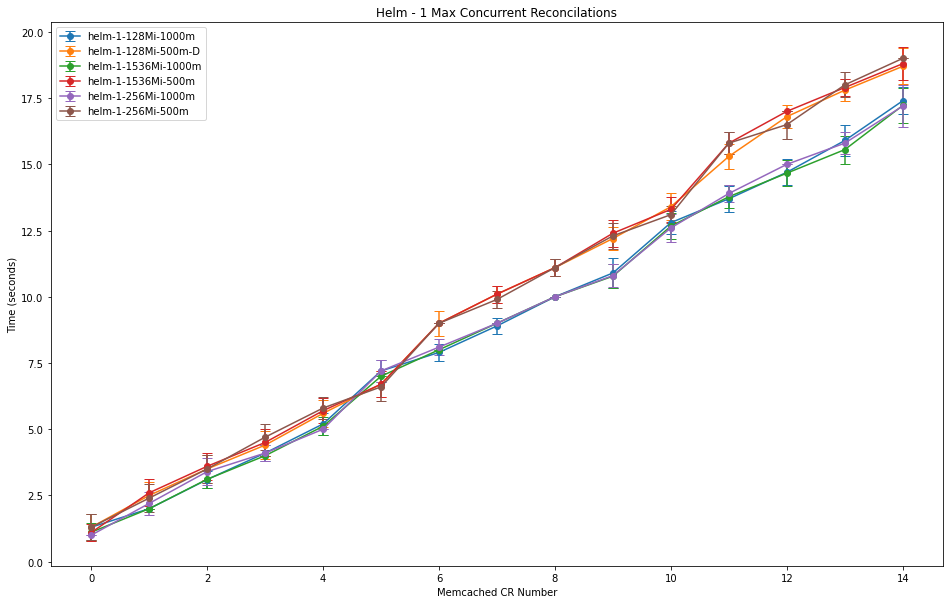

In [235]:
directories = [{
    CR_KEY: getMemcachedsDir(x),
    DEPLOY_KEY: getStatefulSetsDir(x),
} for x in getAllDirOfType(DATA_PATH_1MR, 'helm')]

plt.title('Helm - 1 Max Concurrent Reconcilations')
everythingDf = plotTimeBetweenCRAndDeployment(directories, True)
saveFig('plotHelm1Reconcile.png')

statsTable = groupByColumn(everythingDf, 'type')[DIF_TIME_COL]
saveTableAsImage(statsTable, 'tableStatsHelm1Reconcile.png')

## 2.3 Go
### 2.3.1 Max Concurrent Reconcile - Default - 1

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

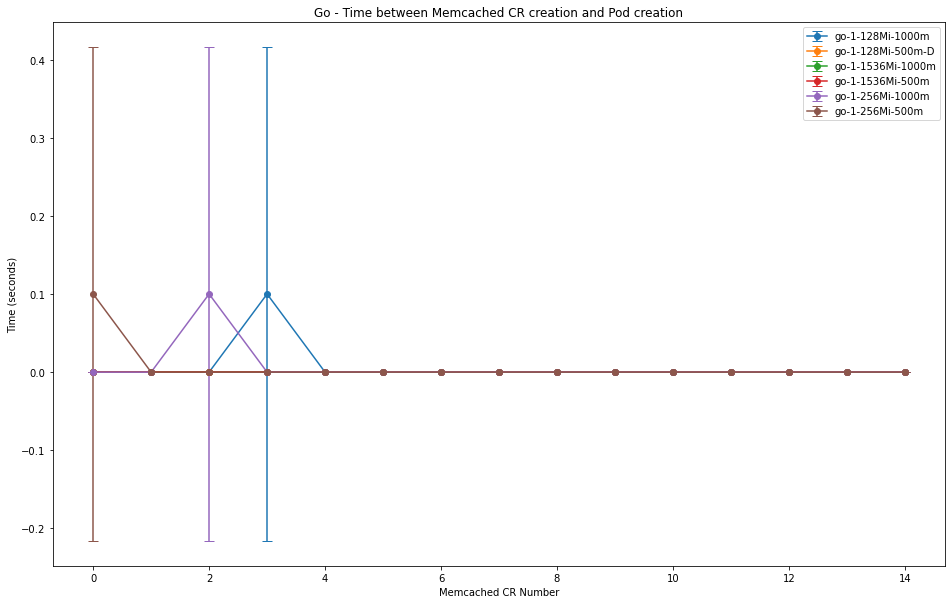

In [236]:
goDirectories = [{
    CR_KEY: getMemcachedsDir(x),
    DEPLOY_KEY: getDeploymentDir(x),
} for x in getAllDirOfType(DATA_PATH, 'go')]

everythingDf = plotTimeBetweenCRAndDeployment(goDirectories, True)

plt.title('Go - Time between Memcached CR creation and Pod creation')
saveFig('plotGoTimeBetweenCRAndDeployment.png')

statsTable = groupByColumn(everythingDf, 'type')[DIF_TIME_COL]
saveTableAsImage(statsTable, 'tableStatsGo1Reconcile.png')

# 3 Comparisons
## 3.1 Default Configuration
### 3.1.1 Operator Container CPU & Memory

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])


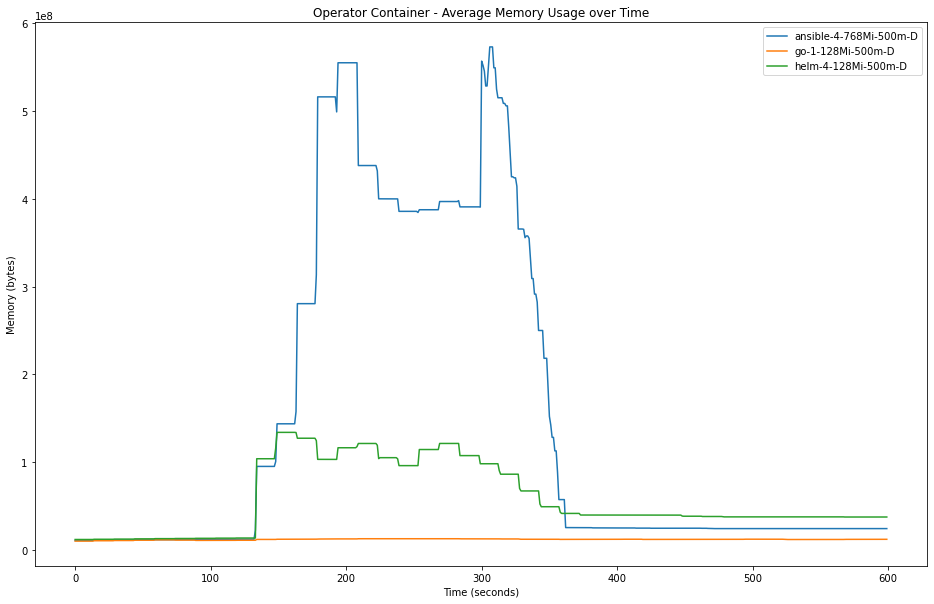

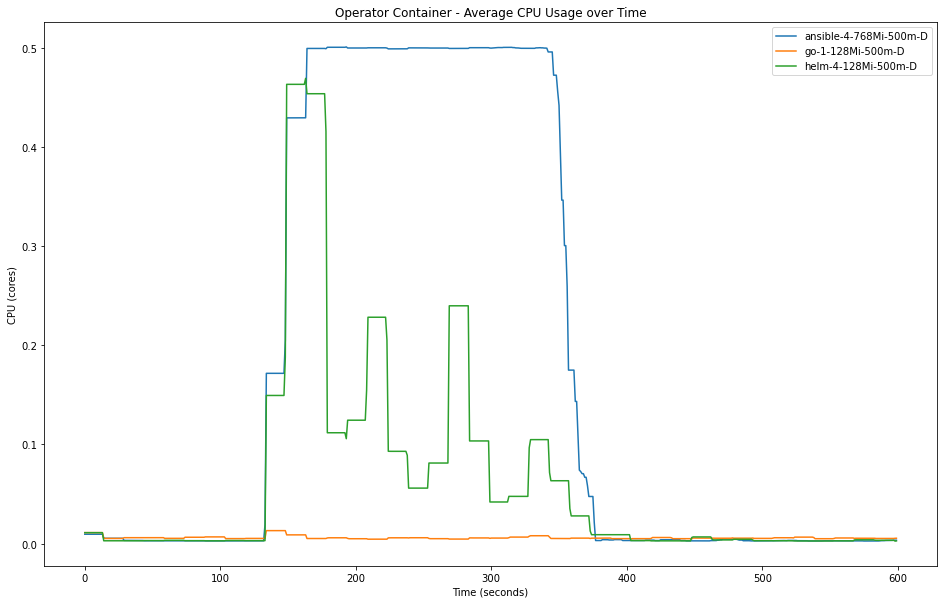

In [237]:
directories = getDefaultConfDirs()

maxMemStats, maxCPUStats =  averageCPUMemoryUsage(directories)

plt.figure(0)
plt.title("Operator Container - Average Memory Usage over Time")
saveFig('plotAverageOperatorMemoryCompare.png')

plt.figure(1)
plt.title("Operator Container - Average CPU Usage over Time")
saveFig('plotAverageOperatorCPUCompare.png')

In [238]:
# Save maxstats table
generateAndSaveMeanTables(maxMemStats, 'tableMaxMemoryTime.png', 'tableRatioMemory.png')
maxMemStats

[0904/184604.567170:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184604.643480:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184604.807737:INFO:headless_shell.cc(660)] Written to file /tmp/tmpkhmvfy_s/temp.png.
[0904/184604.971083:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184605.050707:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184605.203759:INFO:headless_shell.cc(660)] Written to file /tmp/tmpcg6e2x8i/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
306,572662169.6,1.282508e+08,364544000,729993216,4.055647e+07,ansible-4-768Mi-500m-D
210,13000704.0,2.575961e+05,12439552,13418496,8.145904e+04,go-1-128Mi-500m-D
149,134027673.6,1.578623e+05,133709824,134217728,4.992044e+04,helm-4-128Mi-500m-D


In [239]:
# Save maxCPU table
generateAndSaveMeanTables(maxCPUStats, 'tableMaxCPUtime.png', 'tableRatioCPU.png')
maxCPUStats

[0904/184605.377962:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184605.455470:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184605.604090:INFO:headless_shell.cc(660)] Written to file /tmp/tmpgqngqrjy/temp.png.
[0904/184605.762844:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184605.838110:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184605.987143:INFO:headless_shell.cc(660)] Written to file /tmp/tmpno3jq6p3/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
193,0.500771,0.001015,0.498734,0.502174,0.000321,ansible-4-768Mi-500m-D
134,0.013080,0.002187,0.010696,0.017253,0.000691,go-1-128Mi-500m-D
163,0.469068,0.065194,0.288693,0.500806,0.020616,helm-4-128Mi-500m-D


### 3.1.2 Kube Container CPU & Memory

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])


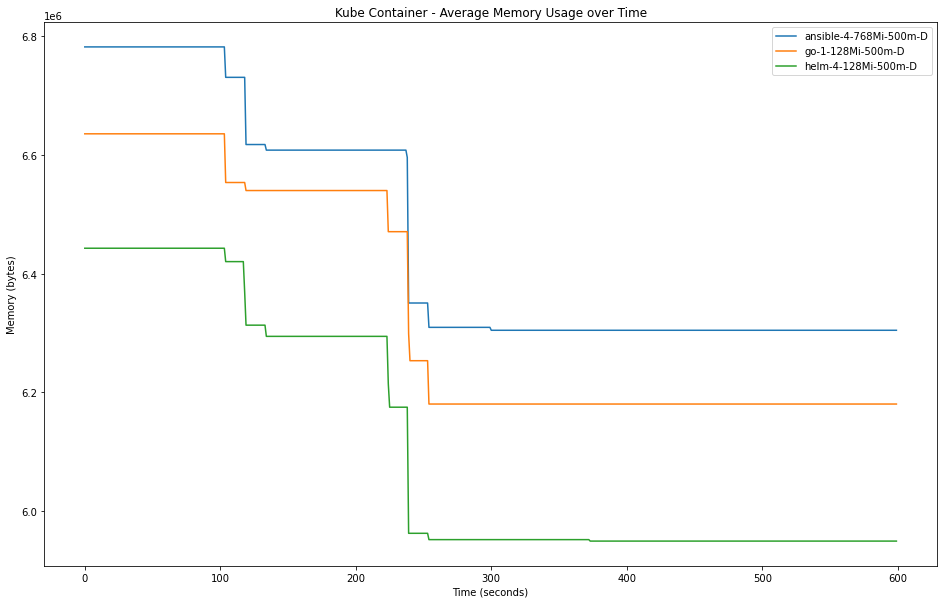

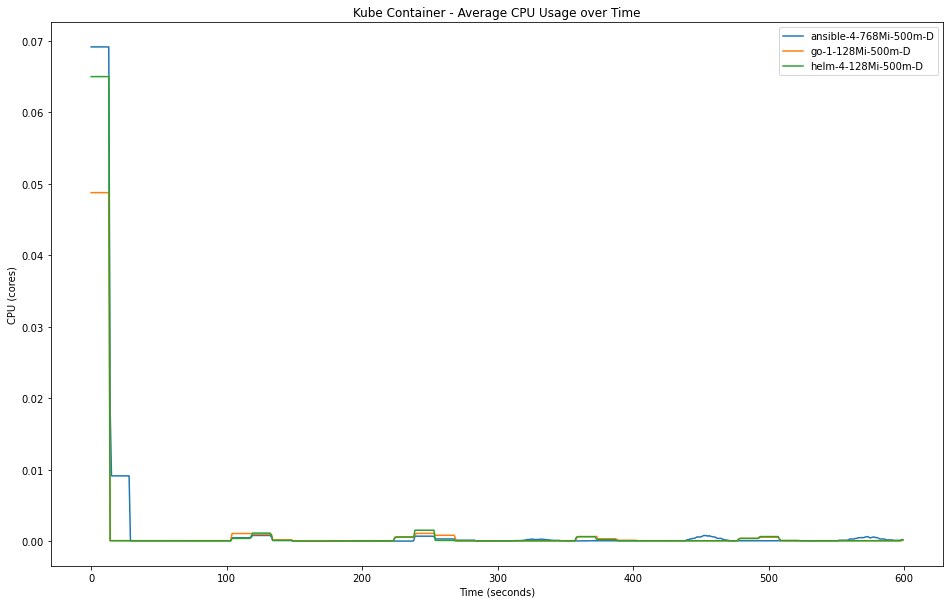

In [240]:
directories = getDefaultConfDirs()
                                                                                          
averageCPUMemoryUsage(directories, KUBE_MEM_USAGE_COL, KUBE_CPU_USAGE_COL)
# Plot Kube container - memory
plt.figure(0)
plt.title("Kube Container - Average Memory Usage over Time")
saveFig('plotAverageKubeMemoryCompare.png')

# Plot Kube container - cpu
plt.figure(1)
plt.title("Kube Container - Average CPU Usage over Time")
saveFig('plotAverageKubeCPUCompare.png')

### 3.1.3 Time for Operator Pod to be Ready state

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['podName', 'createTime', 'readyTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
[0904/184630.095866:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184630.163343:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184630.320239:INFO:headless_shell.cc(660)] Written to file /tmp/tmpz2asfjrp/temp.png.
[0904/184630.498506:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184630.582163:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184630.747446:INFO:headless_shell.cc(660)] Written to file /tmp/tmpum3te7nx/temp.png.


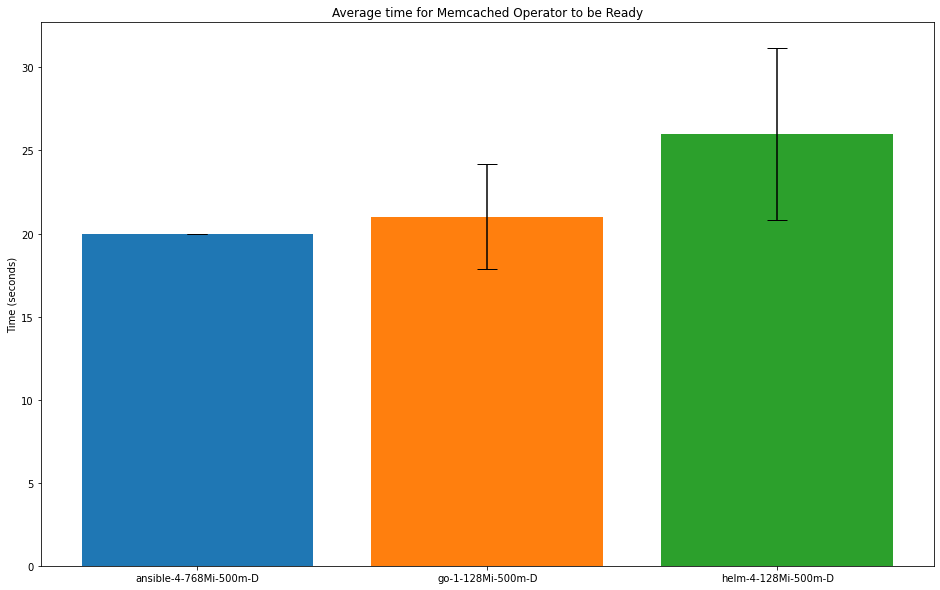

In [241]:
# Time for operator pod to be ready
directories = getDefaultConfDirs()

controllerPodDf, limitsDf = operartorPodReady(directories)

statsTable = groupByColumn(controllerPodDf, 'type')

plt.figure(6)
barChartBetweenType(statsTable, DIF_TIME_COL, TIME_SEC_AX, 'Average time for Memcached Operator to be Ready')
saveFig('plotAveregeTimeForOpreatorPodRun.png')

# Save Limits table as image
saveTableAsImage(limitsDf, 'tableCpuMemoryLimits.png')

saveTableAsImage(statsTable[DIF_TIME_COL], 'tableOperatorReady.png')

### 3.1.4 Time for all Pods Running & Deleted

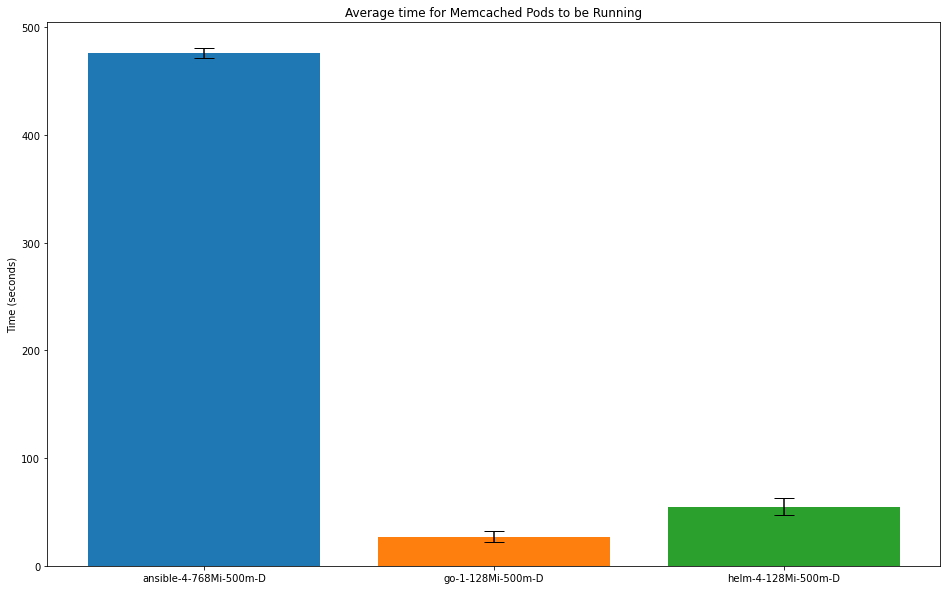

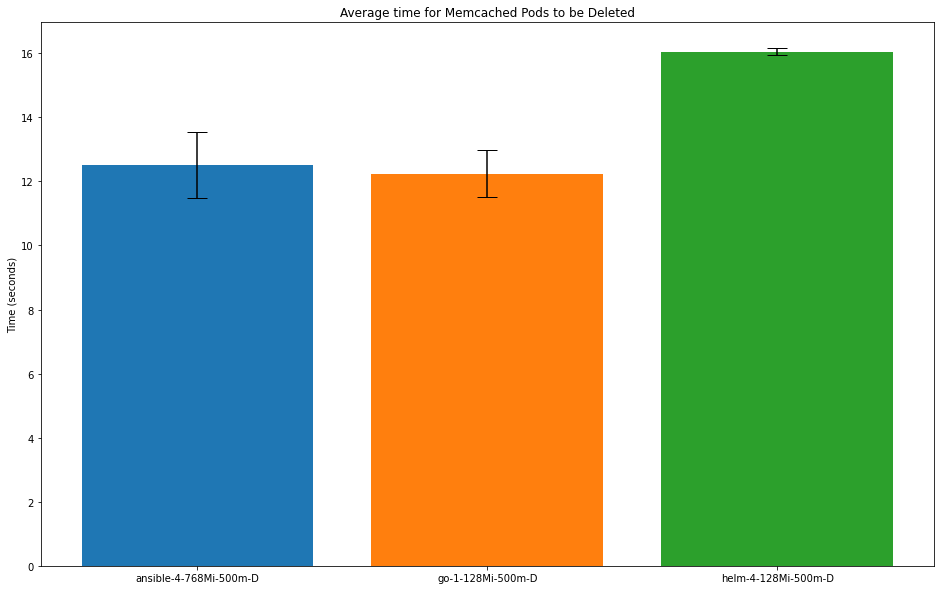

In [242]:
directories = getDefaultConfDirs()

timingDf = timeForMemPodsDf(directories)
statsDf = groupByColumn(timingDf, 'type')

# Bar chart of average time for pods to be in running state
plt.figure(4)
barChartBetweenType(statsDf, 'timeForPodsRunning', TIME_SEC_AX, 
                    'Average time for Memcached Pods to be Running')
saveFig('plotAveregeTimeForMemPodRun.png')

# Bar chart of average time for pods to be deleted
plt.figure(5)
barChartBetweenType(statsDf, 'timeForPodsDeleted', TIME_SEC_AX, 
                    'Average time for Memcached Pods to be Deleted')
saveFig('plotAverageTimeForMemPodDeleted.png')

### 3.1.5 Pod Creation Time

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

number                                 difTime  \
                         mean       std min max       sem        mean   
type                                                                    
ansible-4-768Mi-500m-D    7.0  4.334968   0  14  0.353949  279.946667   
go-1-128Mi-500m-D         7.0  4.334968   0  14  0.353949    0.000000   
helm-4-128Mi-500m-D       7.0  4.334968   0  14  0.353949    8.940000   

                                                            
                               std   min    max        sem  
type                                                        
ansible-4-768Mi-500m-D  148.490607  58.0  475.0  12.124207  
go-1-128Mi-500m-D         0.000000   0.0    0.0   0.000000  
helm-4-128Mi-500m-D       5.657127   1.0   35.0   0.461902

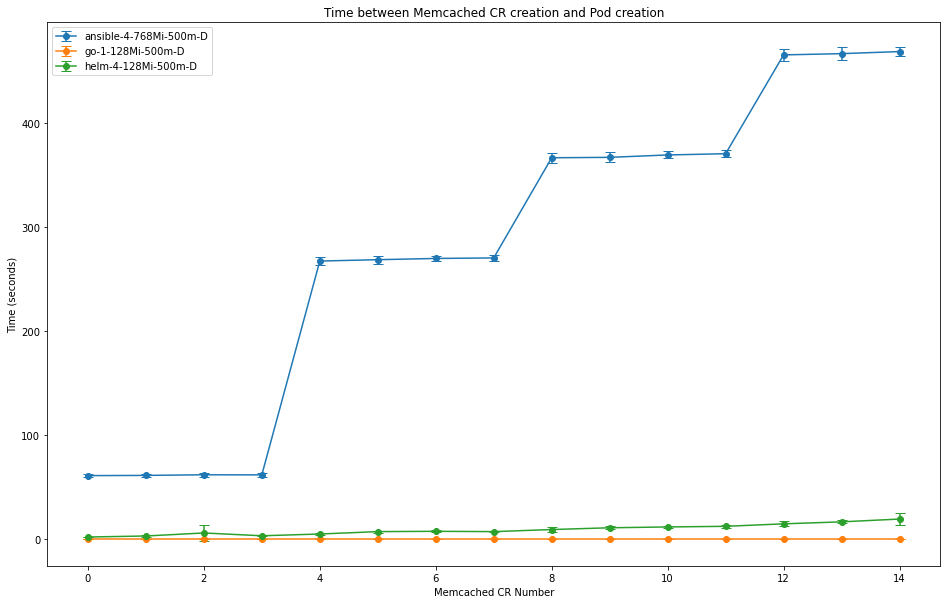

In [243]:
# Time between CR created -> deployment created
directories = [
    getCRAndDeployDirectory('ansible-4-768Mi-500m-D/', appendToDataPath),
    getCRAndDeployDirectory('go-1-128Mi-500m-D/', appendToDataPath),
    getCRAndStateDirectory('helm-4-128Mi-500m-D/', appendToDataPath),
]

everythingDf = plotTimeBetweenCRAndDeployment(directories, True)

plt.title('Time between Memcached CR creation and Pod creation')
saveFig('plotAverageTimeForEachPodReady.png')

everythingDf.groupby(['type']).agg(['mean', 'std', 'min', 'max', 'sem'])

## 3.2 One Max Reconcile & Same Memory / CPU Allocation
### 3.2.1 Operator Container CPU & Memory

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['queryTimestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])


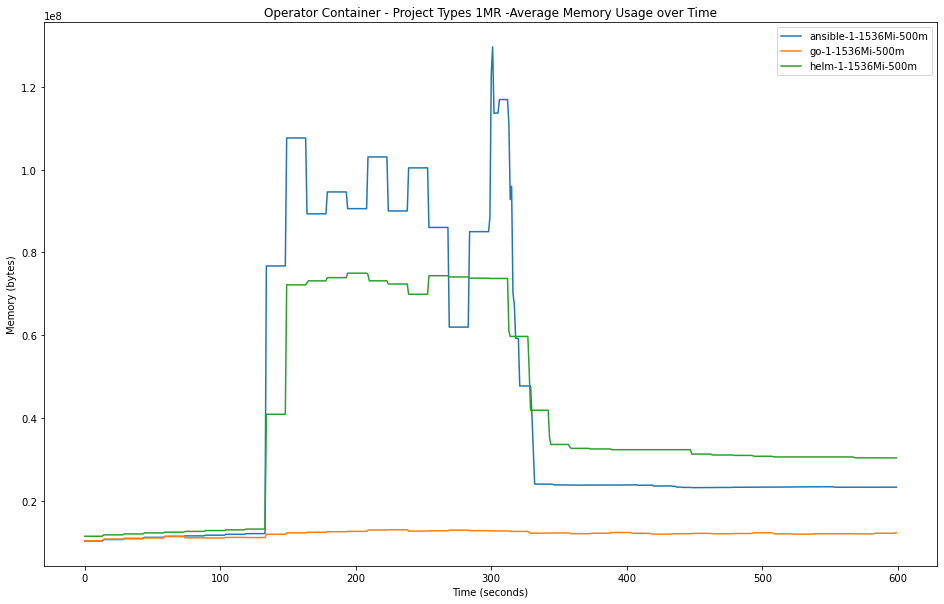

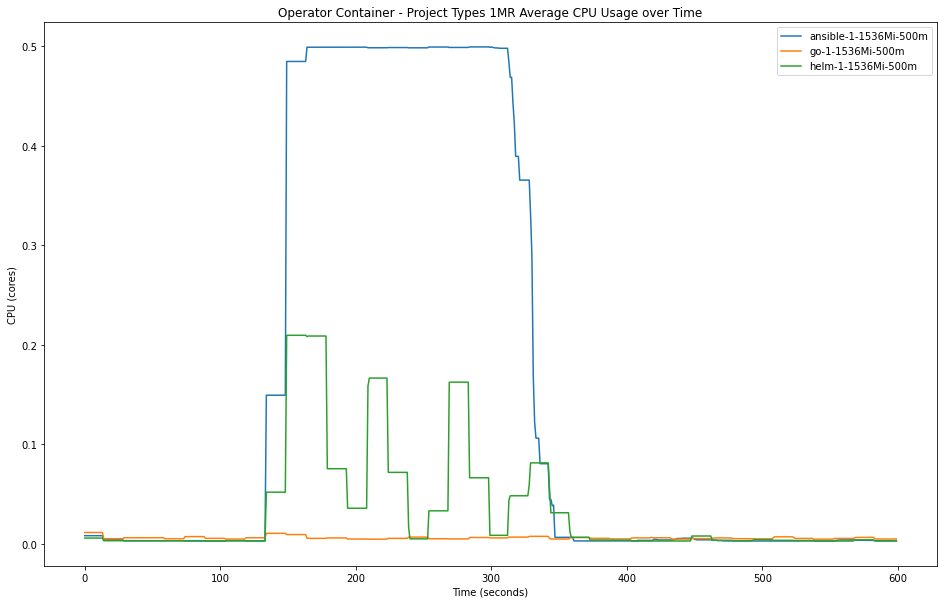

In [244]:
directories = [
    appendToDataPath1MR('ansible-1-1536Mi-500m/'),
    appendToDataPath('go-1-1536Mi-500m/'),
    appendToDataPath1MR('helm-1-1536Mi-500m/'),
]

maxMemStats, maxCPUStats =  averageCPUMemoryUsage(directories)

plt.figure(0)
plt.title("Operator Container - Project Types 1MR -Average Memory Usage over Time")
saveFig('plotAverageOperator1MRMemoryCompare.png')

plt.figure(1)
plt.title("Operator Container - Project Types 1MR Average CPU Usage over Time")
saveFig('plotAverageOperator1MRCPUCompare.png')

In [245]:
saveTableAsImage(maxMemStats, 'tableMax1MRMemoryTime.png')
maxMemStats

[0904/184654.453795:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184654.534643:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184654.686343:INFO:headless_shell.cc(660)] Written to file /tmp/tmpv5qeoy5l/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
301,1.295581e+08,5.901077e+07,52043776,207450112,1.866084e+07,ansible-1-1536Mi-500m
224,1.316181e+07,3.515468e+05,12767232,13742080,1.171823e+05,go-1-1536Mi-500m
194,7.501169e+07,2.758115e+06,70184960,79769600,8.721925e+05,helm-1-1536Mi-500m


In [246]:
saveTableAsImage(maxCPUStats, 'tableMax1MRCPUtime.png')
maxCPUStats

[0904/184654.854739:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184654.933879:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184655.084671:INFO:headless_shell.cc(660)] Written to file /tmp/tmpf_jxe3ss/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean,Type
Time (s),,,,,,
284,0.499195,0.001485,0.497507,0.501328,0.000470,ansible-1-1536Mi-500m
0,0.011300,0.005204,0.004951,0.017428,0.001735,go-1-1536Mi-500m
149,0.209436,0.012904,0.182154,0.226815,0.004080,helm-1-1536Mi-500m


In [247]:
ratioTable = generateRatioTable(maxMemStats)
saveTableAsImage(ratioTable, 'tableRatio1MRMemory.png')
ratioTable

[0904/184655.256786:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184655.329260:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184655.485146:INFO:headless_shell.cc(660)] Written to file /tmp/tmpd8guf648/temp.png.


,Type,ansible-1-1536Mi-500m,go-1-1536Mi-500m,helm-1-1536Mi-500m
Time (s),,,,
301,ansible-1-1536Mi-500m,1.000000,9.843485,1.727172
224,go-1-1536Mi-500m,0.101590,1.000000,0.175464
194,helm-1-1536Mi-500m,0.578981,5.699191,1.000000


In [248]:
ratioTable = generateRatioTable(maxCPUStats)
saveTableAsImage(ratioTable, 'tableRatio1MRCPU.png')
ratioTable

[0904/184655.650154:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184655.729393:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184655.884719:INFO:headless_shell.cc(660)] Written to file /tmp/tmpwtwqmwfr/temp.png.


,Type,ansible-1-1536Mi-500m,go-1-1536Mi-500m,helm-1-1536Mi-500m
Time (s),,,,
284,ansible-1-1536Mi-500m,1.000000,44.174843,2.383518
0,go-1-1536Mi-500m,0.022637,1.000000,0.053956
149,helm-1-1536Mi-500m,0.419548,18.533461,1.000000


## 3.3 One vs Four Max Concurrent Reconcile
### 3.3.1 Ansible

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

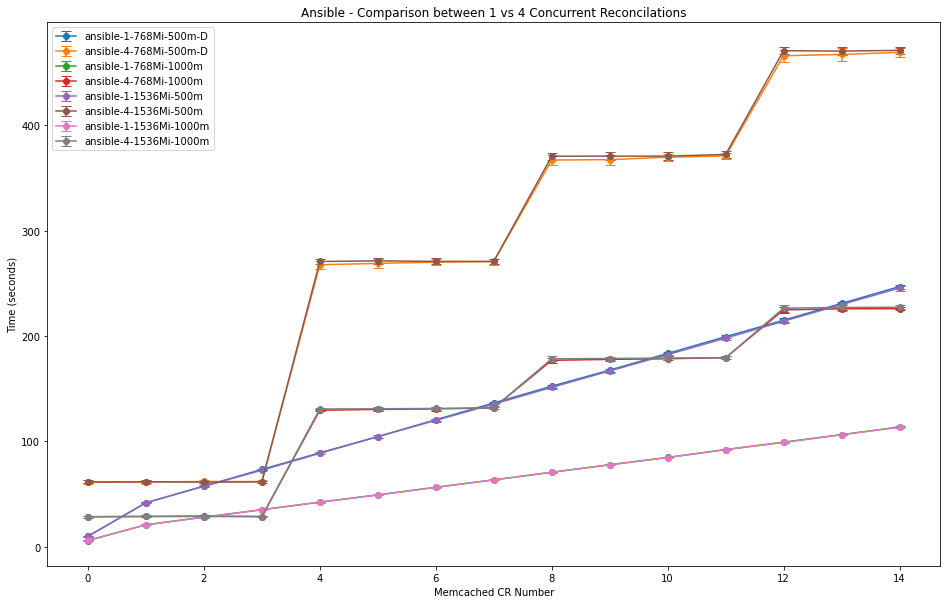

In [249]:
directories = [
    getCRAndDeployDirectory('ansible-1-768Mi-500m-D/', appendToDataPath1MR),
    getCRAndDeployDirectory('ansible-4-768Mi-500m-D/', appendToDataPath),
    getCRAndDeployDirectory('ansible-1-768Mi-1000m/', appendToDataPath1MR),
    getCRAndDeployDirectory('ansible-4-768Mi-1000m/', appendToDataPath),
    getCRAndDeployDirectory('ansible-1-1536Mi-500m/', appendToDataPath1MR),
    getCRAndDeployDirectory('ansible-4-1536Mi-500m/', appendToDataPath),
    getCRAndDeployDirectory('ansible-1-1536Mi-1000m/', appendToDataPath1MR),
    getCRAndDeployDirectory('ansible-4-1536Mi-1000m/', appendToDataPath),
]

everythingDf = plotTimeBetweenCRAndDeployment(directories, True)

plt.title('Ansible - Comparison between 1 vs 4 Concurrent Reconcilations')
saveFig('plotAnsible1vs4Reconcile.png')

In [250]:
statsTable = groupByColumn(everythingDf, 'type')[DIF_TIME_COL]
saveTableAsImage(statsTable, 'tableStatsAnsible1vs4Comparison.png')
statsTable

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
[0904/184657.795347:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184657.879799:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184658.056200:INFO:headless_shell.cc(660)] Written to file /tmp/tmp1wz6pmxv/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean
Type,,,,,
ansible-1-1536Mi-1000m,62.860000,31.717509,6.0,114.0,2.589724
ansible-1-1536Mi-500m,134.373333,69.781783,9.0,249.0,5.697659
ansible-1-768Mi-1000m,62.940000,31.803978,5.0,114.0,2.596784
ansible-1-768Mi-500m-D,135.120000,70.184696,9.0,250.0,5.730556
ansible-4-1536Mi-1000m,135.560000,72.544592,27.0,231.0,5.923241
ansible-4-1536Mi-500m,281.640000,149.667474,59.0,476.0,12.220298
ansible-4-768Mi-1000m,134.980000,72.035456,27.0,230.0,5.881670
ansible-4-768Mi-500m-D,279.946667,148.490607,58.0,475.0,12.124207


In [251]:
ratioTable = generateRatioTable(statsTable)
saveTableAsImage(ratioTable, 'table1vs4AnsibleRatio.png')
ratioTable

[0904/184658.253264:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184658.323291:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184658.489378:INFO:headless_shell.cc(660)] Written to file /tmp/tmpkx5q13__/temp.png.
[0904/184658.638441:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184658.712041:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184658.922279:INFO:headless_shell.cc(660)] Written to file /tmp/tmp5cjvtcfh/temp.png.


,ansible-1-1536Mi-1000m,ansible-1-1536Mi-500m,ansible-1-768Mi-1000m,ansible-1-768Mi-500m-D,ansible-4-1536Mi-1000m,ansible-4-1536Mi-500m,ansible-4-768Mi-1000m,ansible-4-768Mi-500m-D
Type,,,,,,,,
ansible-1-1536Mi-1000m,1.000000,0.467801,0.998729,0.465216,0.463706,0.223193,0.465699,0.224543
ansible-1-1536Mi-500m,2.137660,1.000000,2.134943,0.994474,0.991246,0.477110,0.995506,0.479996
ansible-1-768Mi-1000m,1.001273,0.468397,1.000000,0.465808,0.464296,0.223477,0.466291,0.224829
ansible-1-768Mi-500m-D,2.149539,1.005557,2.146806,1.000000,0.996754,0.479761,1.001037,0.482663
ansible-4-1536Mi-1000m,2.156538,1.008831,2.153797,1.003256,1.000000,0.481324,1.004297,0.484235
ansible-4-1536Mi-500m,4.480433,2.095952,4.474738,2.084369,2.077604,1.000000,2.086531,1.006049
ansible-4-768Mi-1000m,2.147311,1.004515,2.144582,0.998964,0.995721,0.479264,1.000000,0.482163
ansible-4-768Mi-500m-D,4.453495,2.083350,4.447834,2.071837,2.065113,0.993988,2.073986,1.000000


### 3.3.2 Helm

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'type', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max

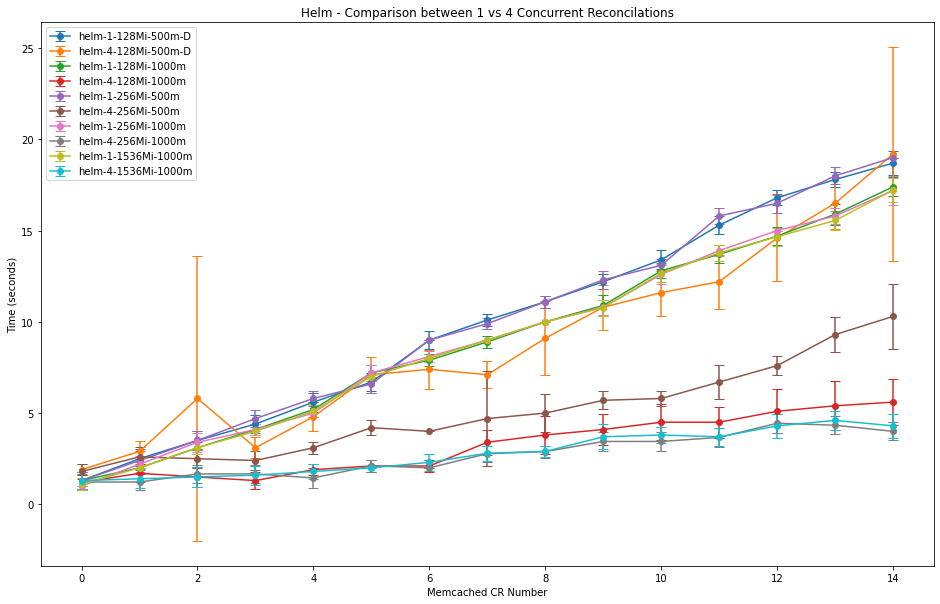

In [252]:
directories = [
    getCRAndStateDirectory('helm-1-128Mi-500m-D/', appendToDataPath1MR),
    getCRAndStateDirectory('helm-4-128Mi-500m-D/', appendToDataPath),
    getCRAndStateDirectory('helm-1-128Mi-1000m/', appendToDataPath1MR),
    getCRAndStateDirectory('helm-4-128Mi-1000m/', appendToDataPath),
    getCRAndStateDirectory('helm-1-256Mi-500m/', appendToDataPath1MR),
    getCRAndStateDirectory('helm-4-256Mi-500m/', appendToDataPath),
    getCRAndStateDirectory('helm-1-256Mi-1000m/', appendToDataPath1MR),
    getCRAndStateDirectory('helm-4-256Mi-1000m/', appendToDataPath),
    getCRAndStateDirectory('helm-1-1536Mi-1000m/', appendToDataPath1MR),
    getCRAndStateDirectory('helm-4-1536Mi-1000m/', appendToDataPath),
]

plt.title('Helm - Comparison between 1 vs 4 Concurrent Reconcilations')
everythingDf = plotTimeBetweenCRAndDeployment(directories, True)
saveFig('plotHelm1vs4Reconcile.png')

In [253]:
statsTable = groupByColumn(everythingDf, 'type')[DIF_TIME_COL]
saveTableAsImage(statsTable, 'tableStatsHelm1vs4Comparison.png')
statsTable

/tmp/ipykernel_85224/3362172018.py:292: FutureWarning: ['name', 'createTime', 'deployCreateTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statsDf = df.groupby([col], sort=sort).agg(['mean', 'std', 'min', 'max', 'sem'])
[0904/184701.729203:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184701.811078:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184701.987679:INFO:headless_shell.cc(660)] Written to file /tmp/tmp2tst6k9z/temp.png.


,Mean,Standard Deviation,Minimum,Maximum,Standard Error of the Mean
Type,,,,,
helm-1-128Mi-1000m,9.006667,5.050745,1.0,18.0,0.412392
helm-1-128Mi-500m-D,9.893333,5.605782,1.0,20.0,0.457710
helm-1-1536Mi-1000m,8.933333,5.024121,1.0,18.0,0.432407
helm-1-256Mi-1000m,9.020000,5.038736,1.0,18.0,0.411411
helm-1-256Mi-500m,9.933333,5.636252,1.0,19.0,0.460198
helm-4-128Mi-1000m,3.213333,1.732387,1.0,8.0,0.141449
helm-4-128Mi-500m-D,8.940000,5.657127,1.0,35.0,0.461902
helm-4-1536Mi-1000m,2.800000,1.242427,1.0,5.0,0.101444
helm-4-256Mi-1000m,2.688889,1.193682,1.0,5.0,0.102736


In [254]:
ratioTable = generateRatioTable(statsTable)
saveTableAsImage(ratioTable, 'table1vs4HelmRatio.png')
ratioTable

[0904/184702.239777:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184702.348493:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184702.566878:INFO:headless_shell.cc(660)] Written to file /tmp/tmpj6xmjutw/temp.png.
[0904/184702.732729:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0904/184702.830676:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0904/184703.101601:INFO:headless_shell.cc(660)] Written to file /tmp/tmpa77e2rs7/temp.png.


,helm-1-128Mi-1000m,helm-1-128Mi-500m-D,helm-1-1536Mi-1000m,helm-1-256Mi-1000m,helm-1-256Mi-500m,helm-4-128Mi-1000m,helm-4-128Mi-500m-D,helm-4-1536Mi-1000m,helm-4-256Mi-1000m,helm-4-256Mi-500m
Type,,,,,,,,,,
helm-1-128Mi-1000m,1.000000,0.910377,1.008209,0.998522,0.906711,2.802905,1.007457,3.216667,3.349587,1.784676
helm-1-128Mi-500m-D,1.098446,1.000000,1.107463,1.096822,0.995973,3.078838,1.106637,3.533333,3.679339,1.960370
helm-1-1536Mi-1000m,0.991858,0.902965,1.000000,0.990392,0.899329,2.780083,0.999254,3.190476,3.322314,1.770145
helm-1-256Mi-1000m,1.001480,0.911725,1.009701,1.000000,0.908054,2.807054,1.008949,3.221429,3.354545,1.787318
helm-1-256Mi-500m,1.102887,1.004043,1.111940,1.101256,1.000000,3.091286,1.111111,3.547619,3.694215,1.968296
helm-4-128Mi-1000m,0.356773,0.324798,0.359701,0.356245,0.323490,1.000000,0.359433,1.147619,1.195041,0.636724
helm-4-128Mi-500m-D,0.992598,0.903639,1.000746,0.991131,0.900000,2.782158,1.000000,3.192857,3.324793,1.771466
helm-4-1536Mi-1000m,0.310881,0.283019,0.313433,0.310421,0.281879,0.871369,0.313199,1.000000,1.041322,0.554822
helm-4-256Mi-1000m,0.298544,0.271788,0.300995,0.298103,0.270694,0.836791,0.300771,0.960317,1.000000,0.532805
